In [2]:
import numpy as np 
import pandas as pd 
import os
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis')
sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/Battery')
import analog
from battery import OCVcurve, segment
from analog import logextract
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook
import csv

In [3]:
log_path = '/home/lucas/Documents/Log_Analysis/Battery/Battery 9'
#log_path = '/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/Battery'
print(os.listdir(log_path))
file1 = f'{log_path}/Discharge 200mA/2019-09-20_1_LiHV - Discharge.csv'
#file2 = f'{log_path}/2019-09-06_1_LiHV - Discharge-part2.csv'
#file3 = f'{log_path}/2019-09-09_1_LiHV - Discharge-part3.csv'
file1_charge = f'{log_path}/Charge 200mA/2019-09-26_1_LiHV - Normal-Charge_200mA.csv' 
#file2_charge = f'{log_path}/Charge 200mA/2019-09-10_1_LiHV - Charge-part2.csv' 
#file3_charge = f'{log_path}/Charge 200mA/2019-09-11_1_LiHV - Charge-part3.csv' 

['Discharge 600mA', 'Discharge 200mA', 'Charge 200mA', 'Charge 100mA', 'log_195.csv']


In [4]:
seg1 = segment(path2csv=file1,mode='discharge')
#seg2 = segment(path2csv=file2,mode='discharge')
#seg3 = segment(path2csv=file3,mode='discharge')

In [5]:
seg1_charge = segment(path2csv=file1_charge,mode='charge')
#seg2_charge = segment(path2csv=file2_charge,mode='charge')
#seg3_charge = segment(path2csv=file3_charge,mode='charge')

In [6]:
print(seg1_charge.cell_voltage)
#print(seg2_charge.cell_voltage)
#print(seg3_charge.cell_voltage)

0         3.472
1         3.468
2         3.468
3         3.472
4         3.471
          ...  
206427    4.350
206428    4.353
206429    4.352
206430    4.350
206431    4.352
Name: CellVoltage 1 [V], Length: 206432, dtype: float64


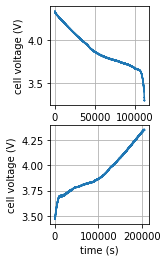

In [7]:
plt.figure()
plt.subplot(231)
seg1.vplot()
plt.ylabel('cell voltage (V)')

#plt.subplot(232)
#seg2.vplot()

#plt.subplot(233)
#seg3.vplot()

plt.subplot(234)
seg1_charge.vplot()
plt.xlabel('time (s)')
plt.ylabel('cell voltage (V)')

#plt.subplot(235)
#seg2_charge.vplot()
#plt.xlabel('time (s)')
#plt.ylabel('cell voltage (V)')

#plt.subplot(236)
#seg3_charge.vplot()
#plt.xlabel('time (s)')
plt.show()

In [8]:
#discharge = seg1.concatenate(seg2.concatenate(seg3))
discharge = seg1

In [9]:
#charge = seg1_charge.concatenate(seg2_charge.concatenate(seg3_charge))
charge = seg1_charge

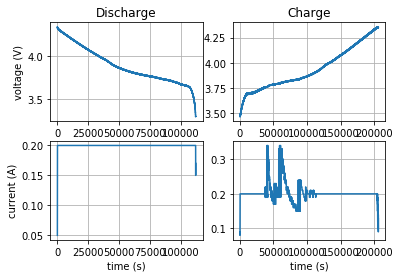

discharge


In [10]:
plt.figure()
plt.subplot(221)
discharge.vplot(label='discharge')
plt.ylabel('voltage (V)')
plt.title('Discharge')
plt.subplot(222)
charge.vplot(label='charge')
plt.title('Charge')
plt.subplot(223)
discharge.cplot(label='discharge')
plt.xlabel('time (s)')
plt.ylabel('current (A)')

plt.subplot(224)
charge.cplot(label='charge')
plt.xlabel('time (s)')
plt.show()

print(discharge.mode)

In [11]:
charge.count_charge(0)
discharge.count_charge(1)

print(f'Total discharge capacity is {round(discharge.Q/3.6,2)} mAh')
print(f'Total charge capacity is {round(charge.Q/3.6,2)} mAh')
eta = discharge.Q/charge.Q
print(eta)

Total discharge capacity is 6229.15 mAh
Total charge capacity is 11568.56 mAh
0.5384551661940014


<IPython.core.display.Javascript object>


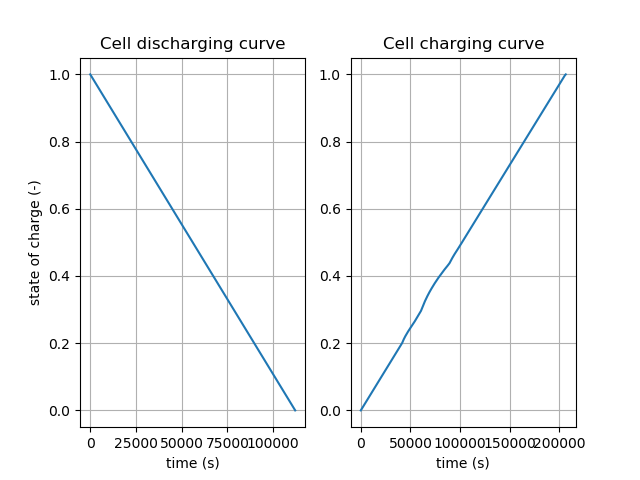

In [12]:
%matplotlib notebook
plt.figure()
plt.subplot(121)
discharge.zplot()
plt.xlabel('time (s)')
plt.ylabel('state of charge (-)')
plt.title('Cell discharging curve')
plt.subplot(122)
charge.zplot()
plt.xlabel('time (s)')
plt.title('Cell charging curve')
plt.show()

In [13]:
charge_OCV = OCVcurve()
charge_OCV.fromsegment(charge)
discharge_OCV = OCVcurve()
discharge_OCV.fromsegment(discharge)

R0 = 0.0123
charge_OCV.intrescorr(R0)
discharge_OCV.intrescorr(R0)

<IPython.core.display.Javascript object>


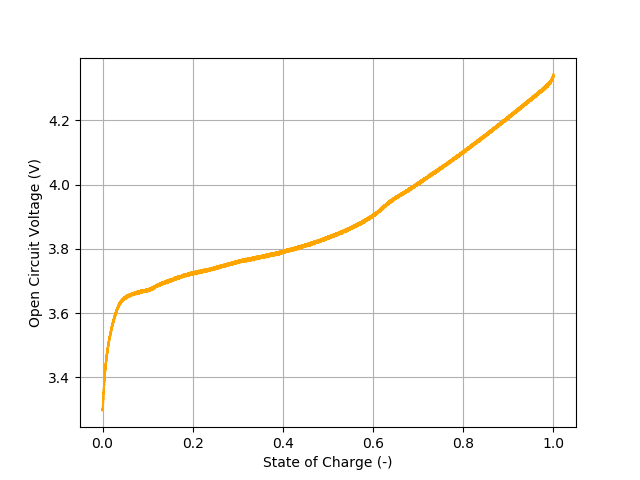

In [15]:
plt.figure()
#charge_OCV.plot()
discharge_OCV.plot(color='orange')
#plt.legend(['charge','discharge'])
#plt.grid()

In [16]:
csv_file = open(f'Battery 9/Charge 200mA/SOCvsOCV_{charge_OCV.mode}200mA.csv','w')
writer = csv.writer(csv_file)
writer.writerow(['SOC','OCV'])
for k in range(len(charge_OCV.SOC)):
    writer.writerow([charge_OCV.SOC.values[k],charge_OCV.OCV.values[k]])

In [17]:
csv_file = open(f'Battery 9/Discharge 200mA/SOCvsOCV_{discharge_OCV.mode}200mA.csv','w')
writer = csv.writer(csv_file)
writer.writerow(['SOC','OCV'])
for k in range(len(discharge_OCV.SOC)):
    writer.writerow([discharge_OCV.SOC.values[k],discharge_OCV.OCV.values[k]])

In [27]:
p = np.polyfit(discharge_OCV.SOC,discharge_OCV.OCV,11)
print(p)

[ 1.54079666e+04 -8.79957879e+04  2.19186396e+05 -3.12687981e+05
  2.82109975e+05 -1.67743633e+05  6.64413360e+04 -1.73142475e+04
  2.86290965e+03 -2.80825943e+02  1.48923600e+01  3.33948616e+00]


<IPython.core.display.Javascript object>


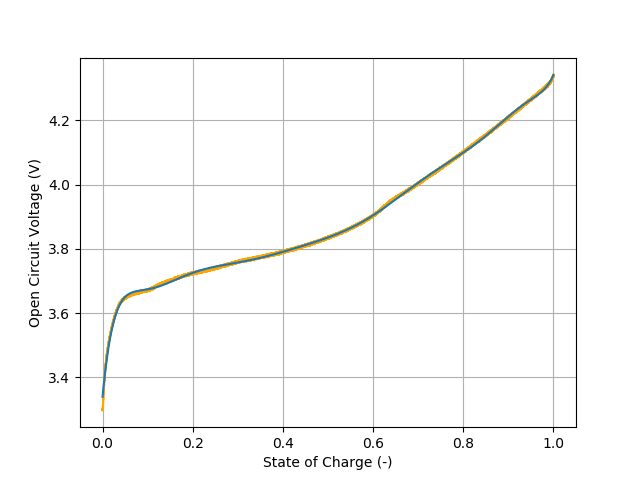

In [26]:
plt.figure()
discharge_OCV.plot(color='orange')
plt.plot(discharge_OCV.SOC,np.polyval(p,discharge_OCV.SOC))